In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random

In [2]:
df = pd.DataFrame()
N = 20
df['x']=[random.random() for i in range(N)]
df['y']=[random.random() for i in range(N)]
df

,x,y
0,0.061871,0.709058
1,0.985891,0.023800
2,0.816979,0.094308
3,0.301882,0.500483
4,0.729545,0.863813
5,0.848528,0.914105
6,0.743942,0.028500
7,0.583924,0.223909
8,0.083004,0.596695
9,0.949340,0.051097


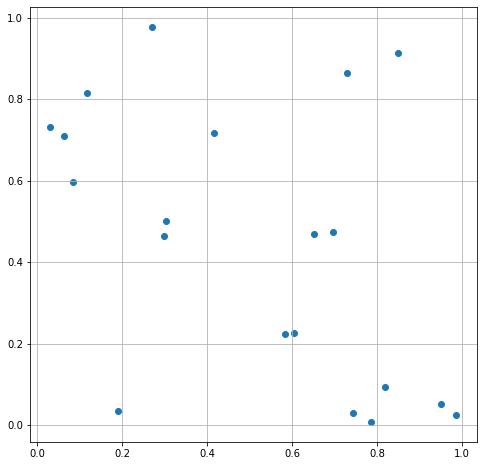

In [3]:
plt.figure(figsize=(8,8))
plt.scatter(df['x'],df['y'])
plt.grid()
plt.savefig(f"base_nopath.png", format='png', dpi=400)  # Save the figure as a PNG image file


In [4]:
def dist(n,m):
    return np.sqrt( (df.loc[n-1,'x']-df.loc[m-1,'x'])**2+(df.loc[n-1,'y']-df.loc[m-1,'y'])**2 )

In [5]:
nodes = [i for i in range(1,1+len(df))]
R= 0.07
dic={(n,m):dist(n,m) for n in nodes for m in nodes if dist(n,m)>0}
cover = []
for (n,m),d in dic.items():
    if d<R and d>0:
        cover+=[(n,m)]
cover

[(1, 12),
 (2, 10),
 (4, 19),
 (7, 11),
 (8, 20),
 (10, 2),
 (11, 7),
 (12, 1),
 (14, 17),
 (17, 14),
 (19, 4),
 (20, 8)]

In [ ]:
N = len(df)
model = AbstractModel()
model.i = RangeSet(N)
model.j = Set(initialize=model.i)

model.U = Var(model.i,model.j, within = Binary)
model.Tour = Var(model.i, within = Binary)
model.M = Var(model.i,model.j,bounds=(0,N), within = NonNegativeReals)

#model.Neighbor = Var(model.i, within = Binary)
model.Order = Var(model.i, bounds=(0,N), within = NonNegativeReals)

def rule_C0(model,i):
    return  sum(model.U[j,i] for j in model.j if (j,i) in dic) == model.Tour[i] 
model.C0 = Constraint(model.i, rule=rule_C0)

def rule_C1(model,i):
    return  sum(model.U[i,j] for j in model.j if (i,j) in dic) == model.Tour[i] 
model.C1 = Constraint(model.i, rule=rule_C1)

# both i,j should be on tour path 
def rule_C1A(model,i,j):
    if (i,j) in dic:
        return  model.U[i,j] <= model.Tour[i] 
    else:
        return Constraint.Skip
model.C1A = Constraint(model.i,model.j, rule=rule_C1A)
def rule_C1B(model,i,j):
    if (i,j) in dic:
        return  model.U[i,j] <= model.Tour[j] 
    else:
        return Constraint.Skip
model.C1B = Constraint(model.i,model.j, rule=rule_C1B)

def rule_C3(model,i):
    return  1- model.Tour[i] <= sum(model.Tour[j] for j in model.j if (i,j) in cover) 
model.C3 = Constraint(model.i, rule=rule_C3)

def rule_C4(model,i,j):
    if j >1 and i>0 and (i,j) in dic:
        return  model.Order[i]- model.Order[j]+ model.M[i,j] <= sum(model.Tour[n] for n in model.i)-1 +10*N*(2-model.Tour[i]-model.Tour[j])
    else:
        return Constraint.Skip
model.C4 = Constraint(model.i,model.j, rule=rule_C4)

def rule_C5(model,i,j):
    if (i,j) in dic:
        return  model.M[i,j] <= N*model.U[i,j]
    else:
        return Constraint.Skip
model.C5 = Constraint(model.i,model.j, rule=rule_C5)

def rule_C6(model,i,j):
    if (i,j) in dic:
        return  model.M[i,j]  <= sum(model.Tour[n] for n in model.i)
    else:
        return Constraint.Skip
model.C6 = Constraint(model.i,model.j, rule=rule_C6)

def rule_C7(model,i,j):
    if (i,j) in dic:
        return  model.M[i,j] >= sum(model.Tour[n] for n in model.i) - (1-model.U[i,j])*N
    else:
        return Constraint.Skip
model.C7 = Constraint(model.i,model.j, rule=rule_C7)

def rule_C8(model,i):
    return  model.Order[i]  <= N*model.Tour[i]
model.C8 = Constraint(model.i, rule=rule_C8)
def rule_C8B(model,i):
    return  model.Order[i]  >= model.Tour[i]
model.C8B = Constraint(model.i, rule=rule_C8B)

def rule_C9(model,i,j):
    if (i,j) in dic and i>j:
        return  model.U[i,j]+model.U[j,i] <=1
    else:
        return Constraint.Skip
model.C9 = Constraint(model.i,model.j, rule=rule_C9)

def rule_of(model):
    return sum(model.U[i,j]*dic[i,j] for i in model.i for j in model.j if (i,j) in dic)
model.obj = Objective(rule=rule_of, sense=minimize)
instance = model.create_instance()

instance.Order[1].fix(1)
instance.Tour[1].fix(1)
    
opt = SolverFactory('cbc')
opt.options = {'sec': 900, 'threads': 4, 'ratio': 0.05}
results = opt.solve(instance)

In [ ]:
print(value(instance.obj))

def circ(x,y,r):
    theta = np.linspace(-np.pi,np.pi,100)
    X= [x+r*cos(th) for th in theta]
    Y= [y+r*sin(th) for th in theta]
    plt.plot(X,Y,'--k', alpha=0.3)    

In [ ]:
plt.figure(figsize=(9,9))
#plt.scatter(df['x'],df['y'],s= 100)
plt.grid()
for j in instance.j:
    #print(j, value(instance.Order[j]) ,value(instance.Tour[j]) )
    for i in instance.i:
        if (i,j) in dic and value(instance.U[i,j])>0:        
            x1,y1 = df.loc[i-1,'x'], df.loc[i-1,'y']
            x2,y2 = df.loc[j-1,'x'], df.loc[j-1,'y']
            plt.plot([x1,x2],[y1,y2])
            plt.scatter(x1,y1,s=100,c='k')
            circ(x1,y1,R)
            print(i,j, value(instance.Order[i]) , value(instance.Order[j]))
for i in instance.i:
    if value(instance.Tour[i]) ==0:
        x1,y1 = df.loc[i-1,'x'], df.loc[i-1,'y']
        plt.scatter(x1,y1,s=20,c='r')
        

plt.savefig(f"path.png", format='png', dpi=400)  # Save the figure as a PNG image file


In [ ]:
results.write()